# Supplementary Figures

## Setup

In [1]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [2]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *
from single_cell import *
from brainspan import *
from maps_data import *
from maps_analysis import *
from maps_null_test import *
from disorders_data import *
from disorders import *

In [19]:
%%R 
source("../code/fig_supplement.R")

In [3]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [4]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

---

### Hawrylycz 2012 PCs

In [6]:
hawrylycz_pcs = pd.read_csv("../data/hawrylycz2012_1000genePCs.csv")
hawrylycz_pcs_brain1 = hawrylycz_pcs.iloc[:,:11].set_index('Gene.B1').rename({'PC 1':'PC1','PC 2':'PC2','PC 3':'PC3'}, axis=1)
hawrylycz_pcs_brain2 = hawrylycz_pcs.iloc[:,11:].set_index('Gene.B2').rename({'PC 1.1':'PC1','PC 2.1':'PC2','PC 3.1':'PC3'}, axis=1)

hawrylycz_pcs = pd.concat({
    'Brain 1 genes': hawrylycz_pcs_brain1.loc[:, ['PC1','PC2','PC3']], 
    'Brain 2 genes': hawrylycz_pcs_brain2.loc[:, ['PC1','PC2','PC3']]
})
hawrylycz_pcs

PC1       PC2       PC3
Brain 1 genes FXYD6       0.983016 -0.033648 -0.018557
              TUBB2A      0.982698  0.023474  0.025298
              SUMO3       0.979685 -0.027263  0.028489
              POLR3K      0.979399  0.040162  0.025744
              MTCH1       0.978731  0.031108 -0.026919
...                            ...       ...       ...
Brain 2 genes TUBB2B      0.501143  0.035008  0.074143
              TNN         0.696344  0.074340  0.030996
              GPC5        0.938291 -0.139395 -0.191785
              THC2555234 -0.499592  0.456087 -0.455869
              TLR4        0.875941 -0.033911 -0.001080

[2000 rows x 3 columns]

In [7]:
hawrylycz_pcs_corr = (weights
                      .join(hawrylycz_pcs.reset_index(0).rename({'level_0':'brain'}, axis=1))
                      .dropna()
                      .groupby('brain')
                      .apply(lambda x: x.corr().iloc[:3,3:])
)
hawrylycz_pcs_corr

PC1       PC2       PC3
brain                                         
Brain 1 genes C1 -0.829692  0.513792  0.023914
              C2  0.348880  0.523125 -0.631172
              C3  0.445980  0.347324  0.398953
Brain 2 genes C1 -0.855505 -0.127838 -0.015286
              C2 -0.221910 -0.344512  0.758771
              C3  0.114246 -0.476448 -0.302841

In [8]:
donor1 = '9861'
donor2 = '10021'

# donor1_expression = get_expression_abagen(fetch_hcp(), save_name='base_donor1', donors=donor1, probe_selection='max_intensity')
# donor2_expression = get_expression_abagen(fetch_hcp(), save_name='base_donor2', donors=donor2, probe_selection='max_intensity')
donor1_expression = pd.read_csv("../data/abagen-data/expression/base_donor1.csv", index_col=0)
donor2_expression = pd.read_csv("../data/abagen-data/expression/base_donor2.csv", index_col=0)

donor1_expression = donor1_expression.dropna(how='all', axis=0).dropna(how='all', axis=1)
donor2_expression = donor2_expression.dropna(how='all', axis=0).dropna(how='all', axis=1)

In [9]:
def compute_PCs_and_correlate_weights(expression, genes, weights=weights):
    return (expression.loc[:,lambda x: np.intersect1d(x.columns, genes)]
    .pipe(lambda x: pd.DataFrame(PCA(n_components=3).fit(x).components_.T, index=x.columns))
    .set_axis(['PC1','PC2','PC3'], axis=1)
    .join(weights)
    .corr().iloc[3:,:3]
    )

hawrylycz_genes_single_brain_pca_corr = pd.concat({
    'Brain 1 genes': compute_PCs_and_correlate_weights(donor1_expression, hawrylycz_pcs_brain1.index),
    'Brain 2 genes': compute_PCs_and_correlate_weights(donor2_expression, hawrylycz_pcs_brain2.index)
})

all_genes_single_brain_pca_corr = pd.concat({
    'Brain 1 genes': compute_PCs_and_correlate_weights(donor1_expression, donor1_expression.columns),
    'Brain 2 genes': compute_PCs_and_correlate_weights(donor2_expression, donor1_expression.columns)
})

hawrylycz_genes_base_pca_corr = pd.concat({
    'Brain 1 genes': compute_PCs_and_correlate_weights(pca_base.expression, hawrylycz_pcs_brain1.index),
    'Brain 2 genes': compute_PCs_and_correlate_weights(pca_base.expression, hawrylycz_pcs_brain2.index)
})

hawrylycz_genes_3d_ds5_pca_corr = pd.concat({
    'Brain 1 genes': compute_PCs_and_correlate_weights(dme_3d_ds5.expression, hawrylycz_pcs_brain1.index),
    'Brain 2 genes': compute_PCs_and_correlate_weights(dme_3d_ds5.expression, hawrylycz_pcs_brain2.index)
})
all_genes_single_brain_pca_corr

PC1       PC2       PC3
Brain 1 genes C1 -0.545167  0.335993  0.652713
              C2  0.284421 -0.227316  0.030748
              C3  0.126365 -0.110336  0.147452
Brain 2 genes C1 -0.040821 -0.777422 -0.367906
              C2 -0.092110 -0.039350 -0.012895
              C3  0.199499 -0.148855  0.589556

In [ ]:
# compute_PCs_and_correlate_weights(donor1_expression, hawrylycz_pcs_brain1.index, weights=hawrylycz_pcs_brain1.loc[:,['PC1','PC2','PC3']])
# compute_PCs_and_correlate_weights(donor2_expression, hawrylycz_pcs_brain2.index, weights=hawrylycz_pcs_brain2.loc[:,['PC1','PC2','PC3']])

In [10]:
df_hawrylycz_corr = (pd.concat({
    'PCs from Hawrylycz 2012:\n1000 most-variable genes\nfrom single-brain data\nin 56-gyri parcellation': hawrylycz_pcs_corr,
    'Same 1000 most-variable genes,\nPCs from single-brain data\nin HCP-MMP parcellation': hawrylycz_genes_single_brain_pca_corr,
    'Same 1000 most-variable genes,\nPCs from unfiltered 6-brain data\nin HCP-MMP parcellation': hawrylycz_genes_base_pca_corr,
    'Same 1000 most-variable genes,\nPCs from filtered 6-brain data\nin HCP-MMP parcellation': hawrylycz_genes_3d_ds5_pca_corr
}).melt(ignore_index=False, var_name='PC', value_name='r')
.reset_index().rename({'level_0':'data', 'level_2':'C'}, axis=1)
)

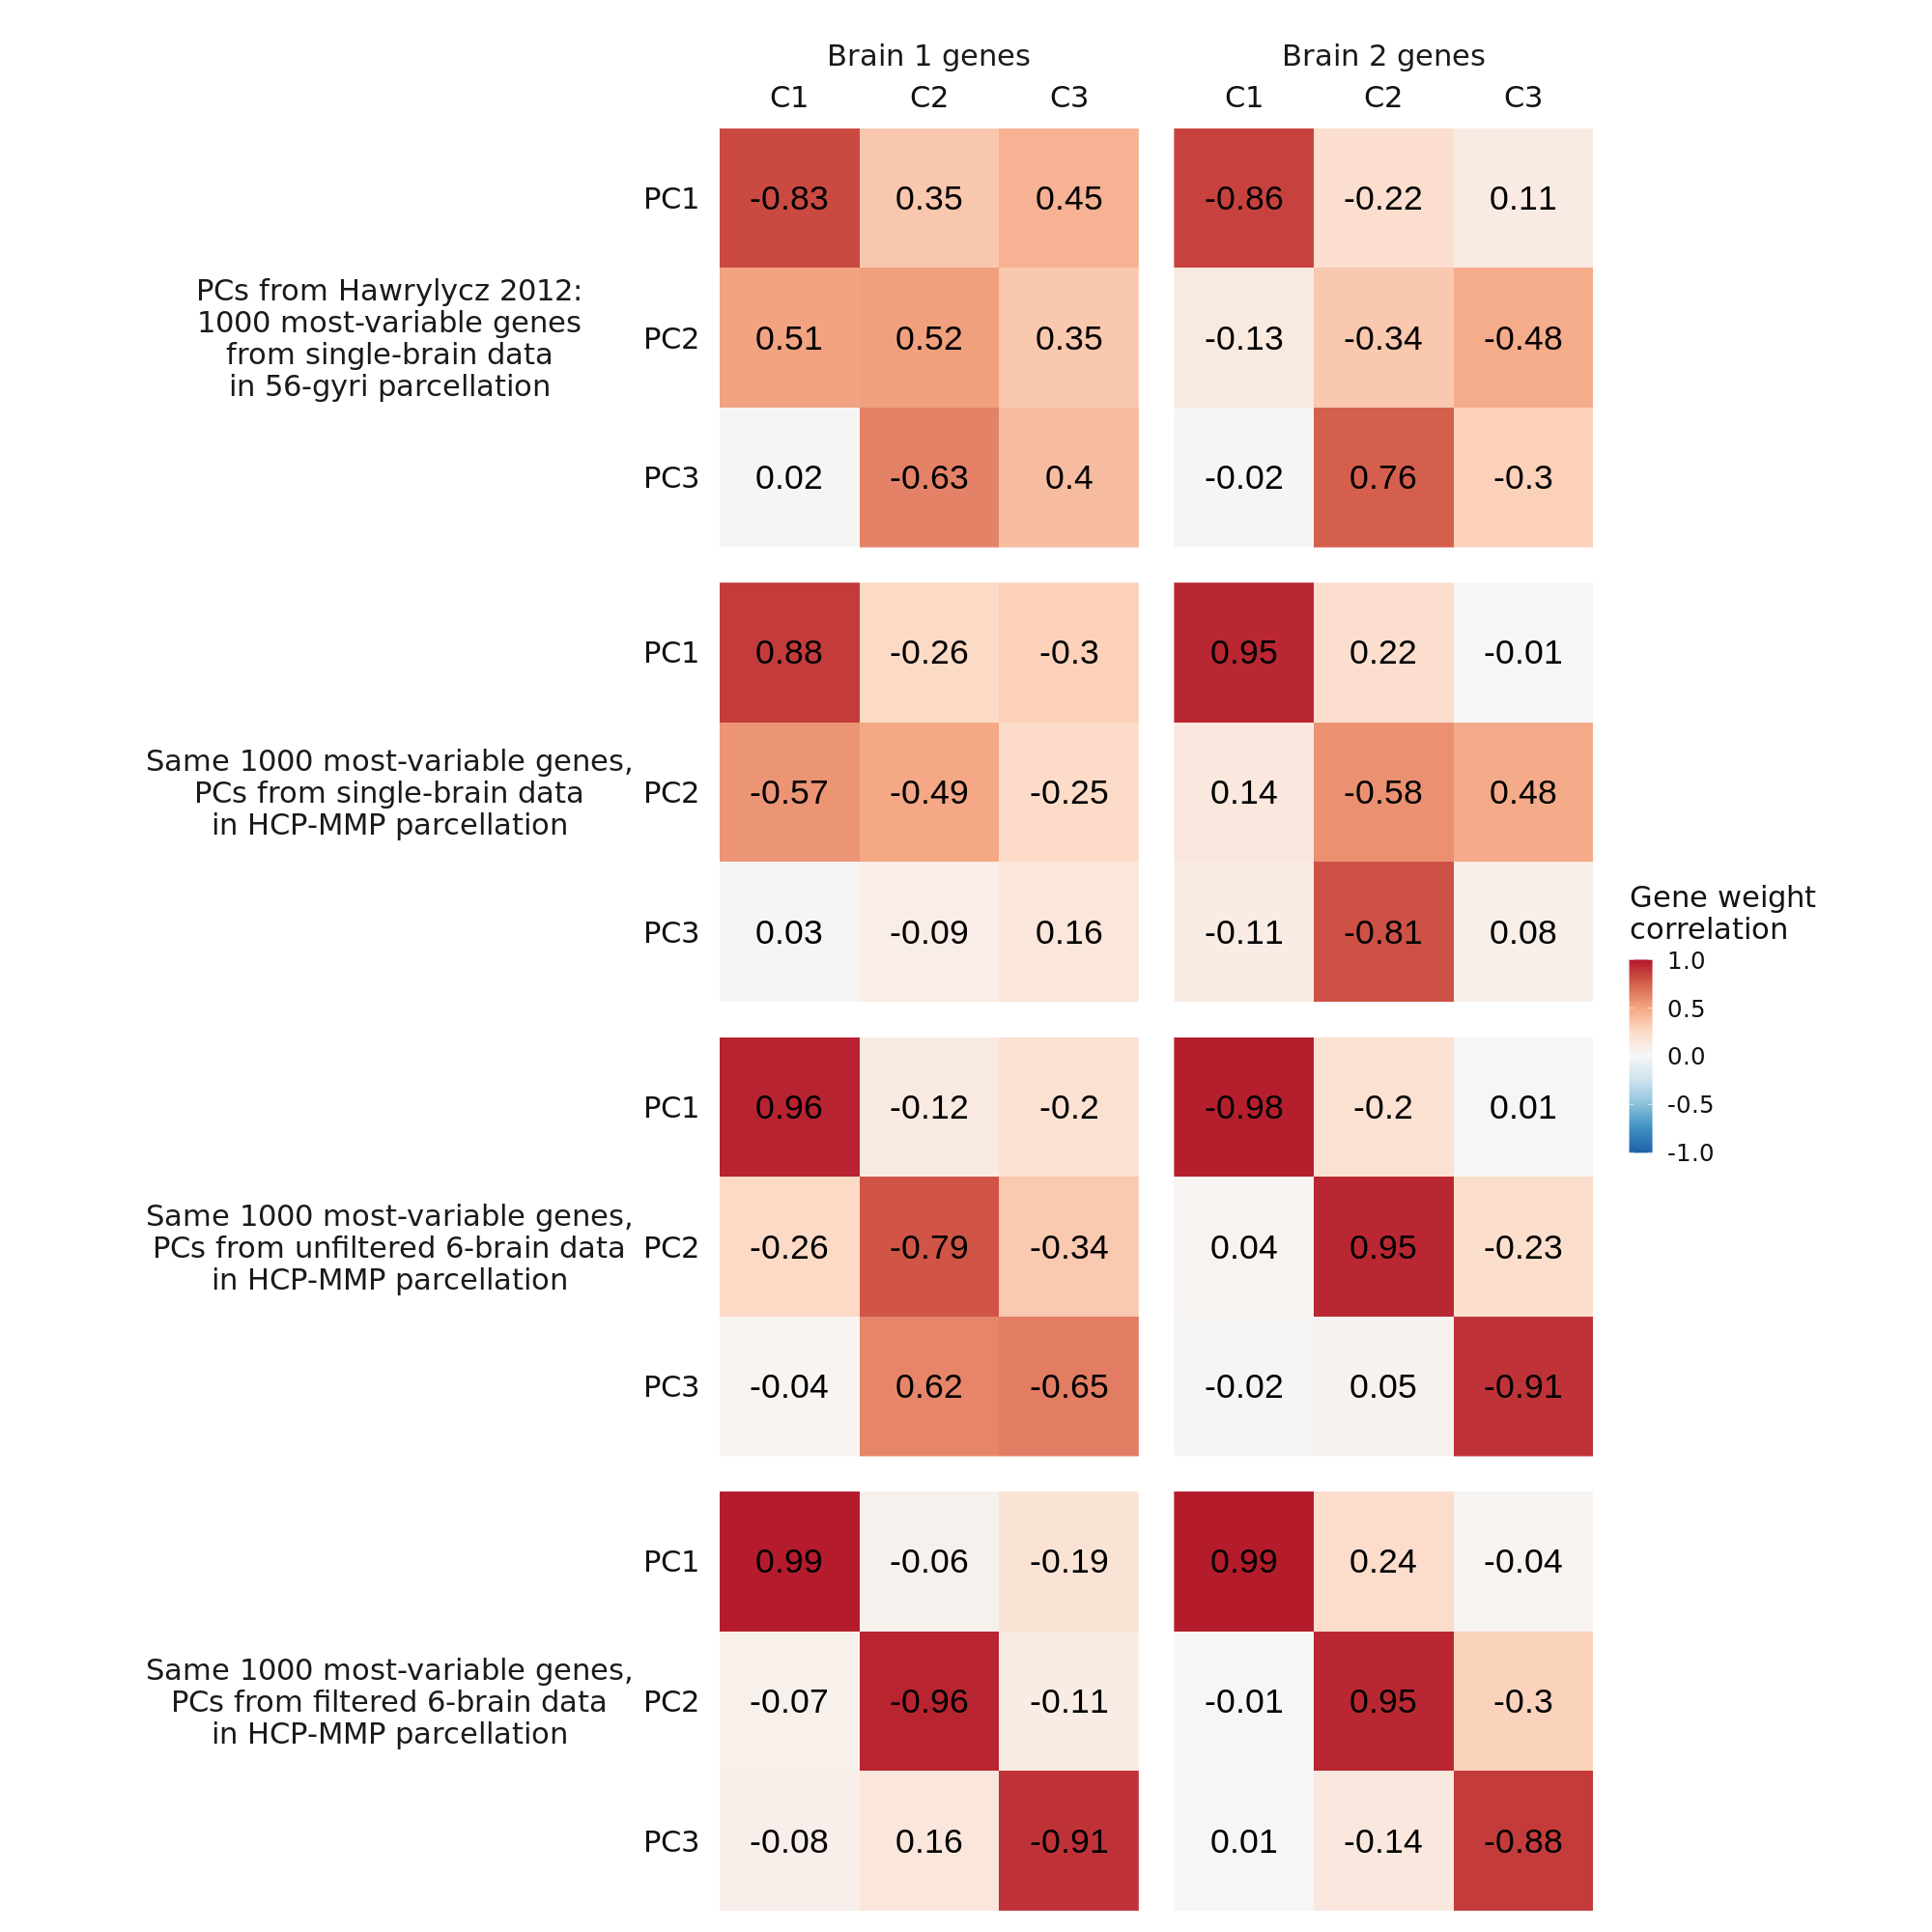

In [11]:
%%R -i df_hawrylycz_corr -w 20 -h 20 -u in -r 100
df_hawrylycz_corr %>% 
mutate(data=factor(data, ordered=T, levels=unique(.$data))) %>% 
ggplot(aes(x=C, y=PC)) + 
facet_grid(data~brain, switch='y') +
geom_raster(aes(fill=abs(r))) +
geom_text(aes(label=round(r,2)), vjust=.5, hjust=.5, size=9, color='black') +
scale_fill_gradientn(colors=rev(brewer.rdbu(100))[10:90], limits=c(-1,1),
                     name='Gene weight\ncorrelation') +
scale_x_discrete(position='top') +
scale_y_discrete(limits=rev) +
guides(fill=guide_colorbar(barheight=10)) +
xlab('') + ylab('') +
theme_minimal() +
theme(panel.grid=element_blank(),
        text = element_text(size=22, color='grey7', family='Calibri'),
        axis.text = element_text(size=22, color='grey7', family='Calibri'),
        legend.title=element_text(vjust=1),
        legend.position='right',
        aspect.ratio=1,
        strip.placement='outside',
        strip.text.y.left = element_text(angle=0, vjust=.5, size=22),
        strip.text = element_text(angle=0, vjust=1, size=22)
        )

### Variance explained and number of genes

In [17]:
genes_over_threshold_dict = {}
for threshold in [0.4, 0.5, 0.6]:
    genes_over_threshold_dict[threshold] = pd.DataFrame({
        'VE': get_var_explained(dme_3d_ds5)[:3],
        'n': (dme_3d_ds5.weights.abs() > threshold).sum(),
        'pct': (dme_3d_ds5.weights.abs() > threshold).sum() / len(dme_3d_ds5.weights),
    })

var_explained_bars = (pd.concat(genes_over_threshold_dict)
 .reset_index().rename({'level_0':'threshold', 'level_1':'C'}, axis=1)
)

# var_explained_bars

var_explained_violins = (dme_3d_ds5.weights.abs()
 .melt(var_name='C', value_name='r')
 .join(var_explained_bars.set_index('C'), on='C')
)
# var_explained_violins

`geom_smooth()` using formula = 'y ~ x'


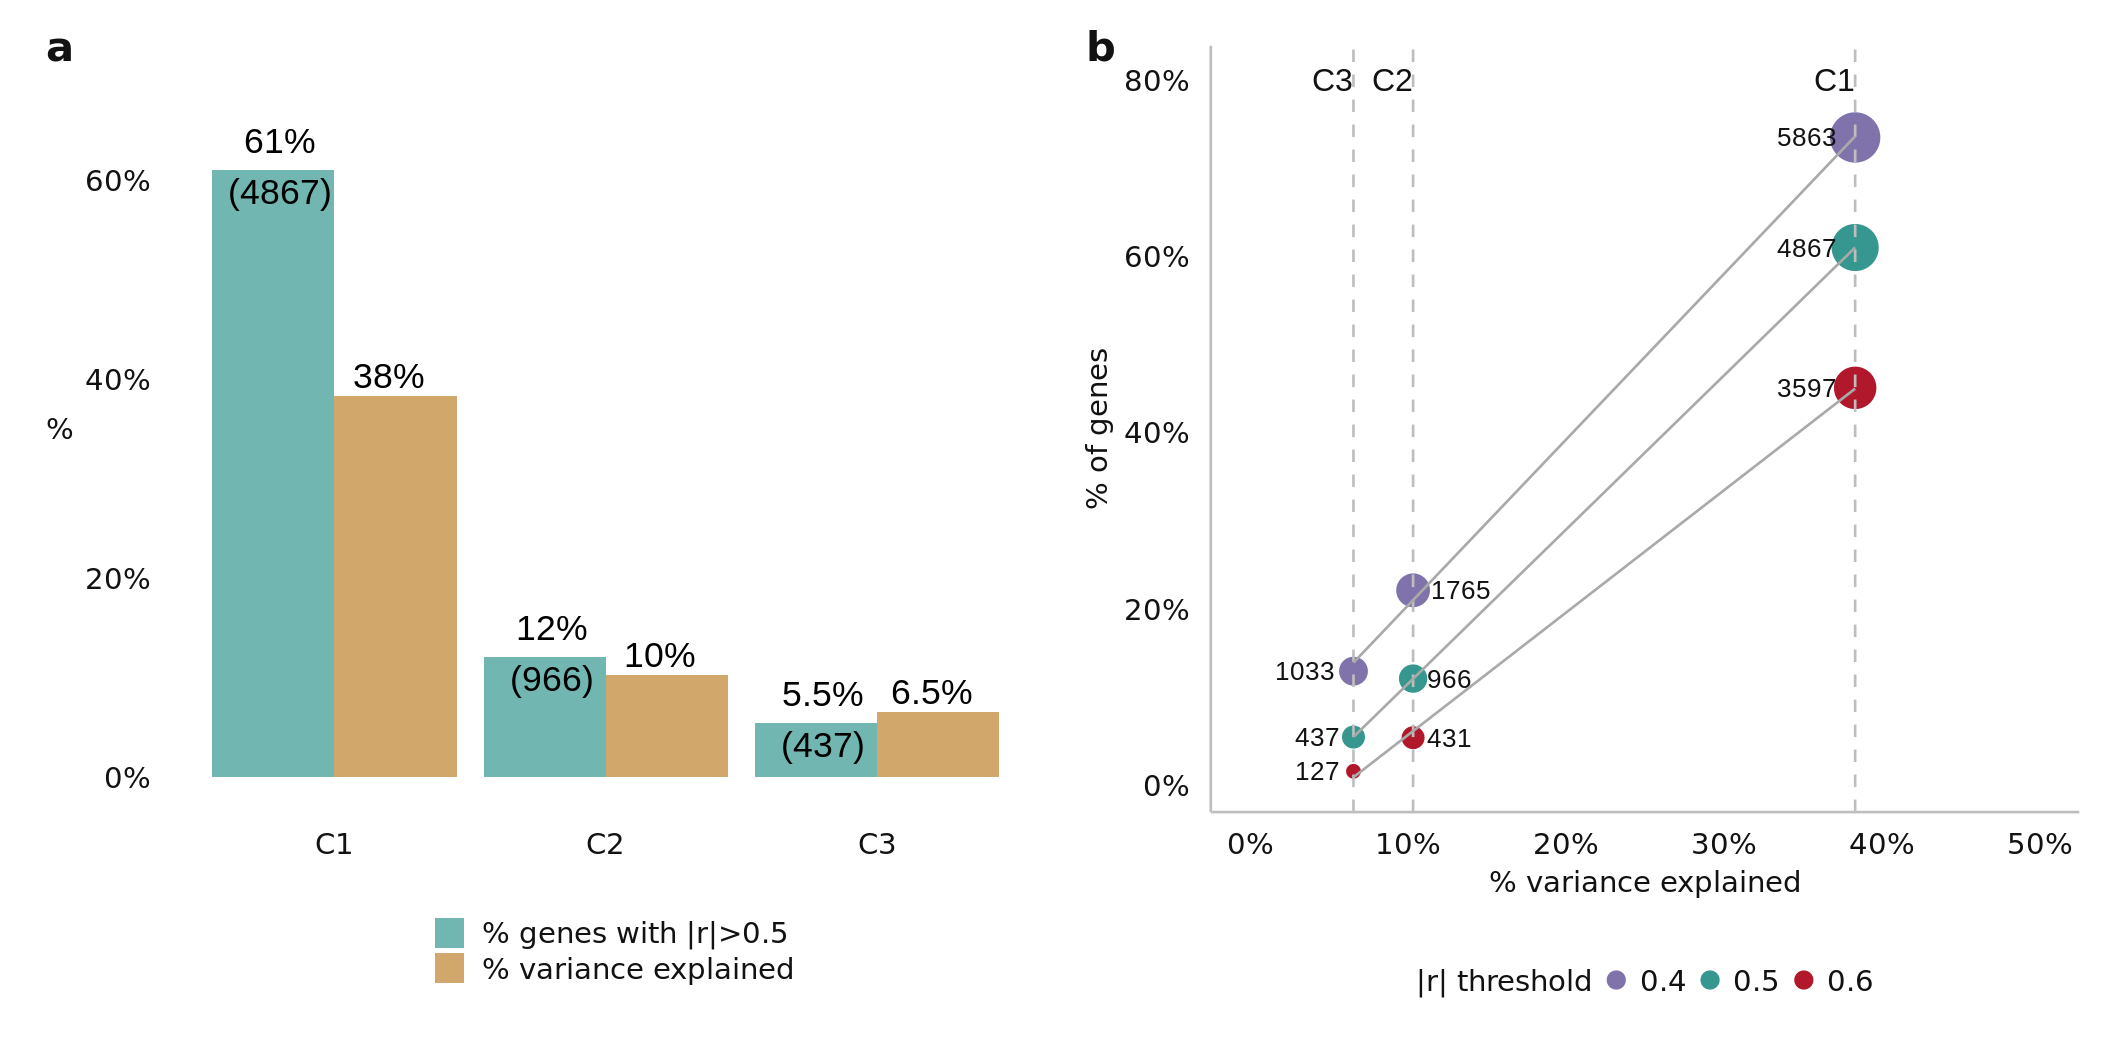

In [20]:
%%R -i var_explained_bars -i var_explained_violins -w 180 -h 90 -u mm -r 300
source("../code/fig_extended.R")

bars <- plot_var_explained_bars(var_explained_bars %>% filter(threshold=='0.5')) #+ inset_element(scatter, left=0.5, right=1, bottom=0.5, top=1, align_to='full')
scatter <- plot_var_explained_scatter(var_explained_bars)
# # violins <- plot_var_explained_violins(var_explained_violins)
bars + scatter + plot_annotation(tag_level='a')

### Burt single gene enrichments

In [21]:
burt_genes = ['CORT','CALB1','SST','PVALB','CCK','NPY','PNOC','CALB2','VIP']
burt_genes = pd.DataFrame({'gene':burt_genes, 'label':burt_genes})
burt_stats = compute_null_p(*compute_enrichments(weights, null_weights, burt_genes))

In [22]:
grin_genes = ['GRIN' + x for x in ['3A','2B','2C','2A','A','1','3B','2D']]
gabra_genes = ['GABRA' + x for x in ['3','5','2','1','4']]
grin_gabra_genes = grin_genes + gabra_genes
grin_gabra_genes = pd.DataFrame({'gene':grin_gabra_genes, 'label':grin_gabra_genes})
grin_gabra_stats = compute_null_p(*compute_enrichments(weights, null_weights, grin_gabra_genes))

### Neuron subtype enrichments

In [23]:
lake_subtypes = get_cell_genes(which='seidlitz', include='lake_plus_glia', subtype=True, combine_layers=False, add_synapses=False)
order = (lake_subtypes
         .assign(neuro = lambda x: [False if c in ['Endo', 'Oligo', 'Micro', 'OPC', 'Astro'] else True for c in x.label])
         .assign(ex_in = lambda x: [False if 'In' in c else True for c in x.label])
         .sort_values(['neuro', 'ex_in'], ascending=False).label.unique()
        )

lake_stats = compute_null_p(*compute_enrichments(weights, null_weights, lake_subtypes), order=order)

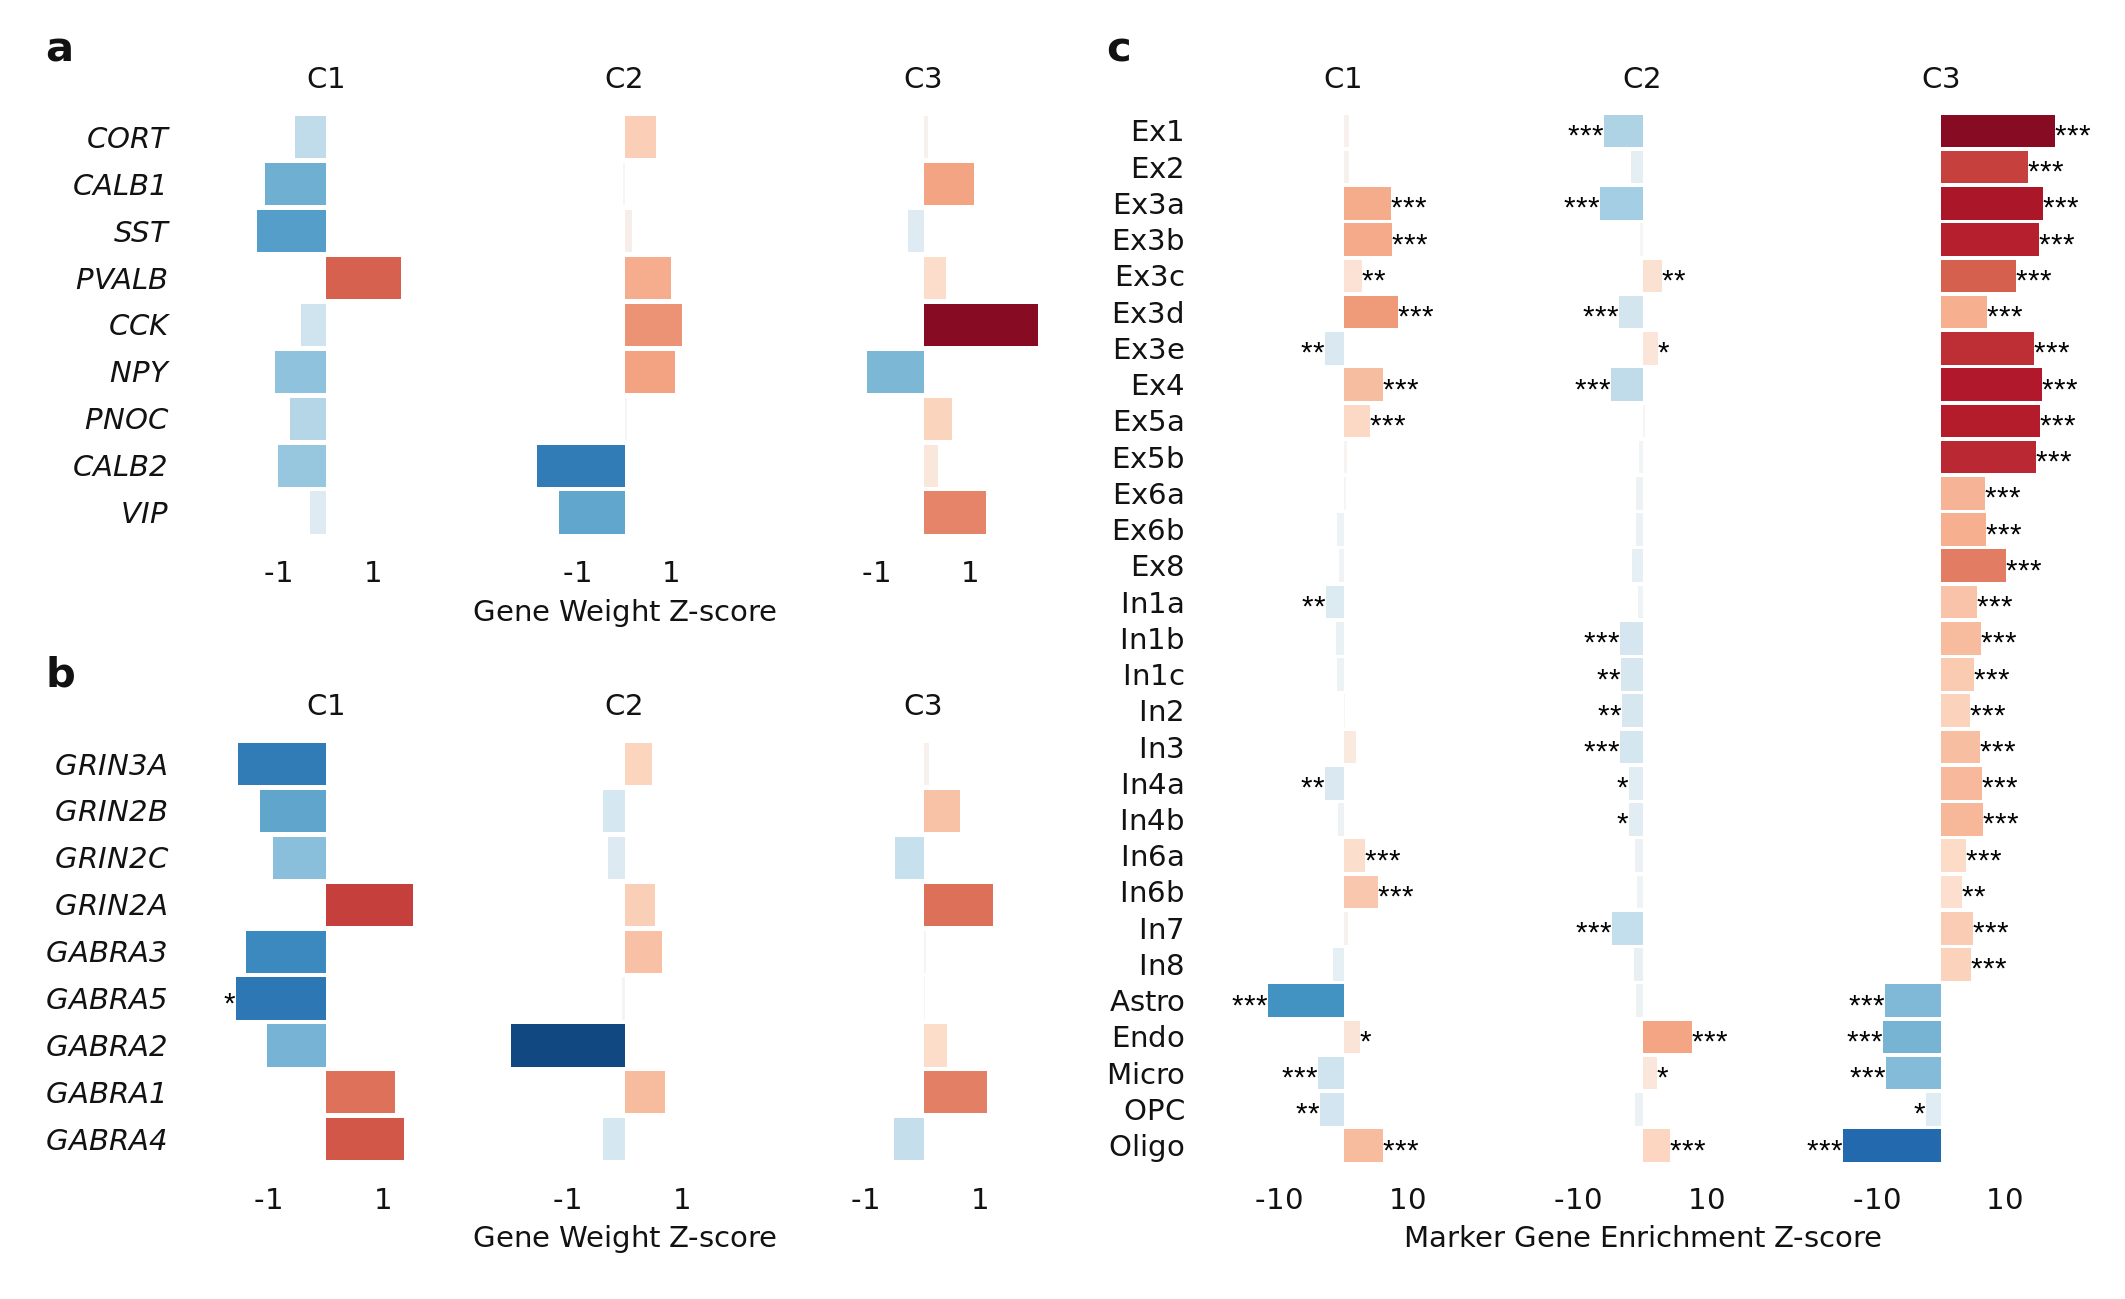

In [24]:
%%R -i burt_stats -i grin_gabra_stats -i lake_stats -w 180 -h 110 -u mm -r 300

g1 = plot_enrichment_bars_z(burt_stats, xlab='Gene Weight Z-score') + theme(axis.text.y=element_text(face='italic'))
g2 = plot_enrichment_bars_z(grin_gabra_stats, xlab='Gene Weight Z-score') + theme(axis.text.y=element_text(face='italic'))
g3 = plot_enrichment_bars_z(lake_stats, xlab='Marker Gene Enrichment Z-score') 

((g1 / g2) | g3) + plot_annotation(tag_level='a')

### Non-overlapping genes

In [ ]:
get_expression_abagen(fetch_hcp(), donors_threshold=3, save_name = 'hcp_3d')

INFO: Donor-specific atlases provided; using native coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 32669 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15946 genes remain after probe filtering + selection
INFO: 458 / 477 samples matched to regions for donor #9861
INFO: 346 / 367 samples matched to regions for donor #10021
INFO: 173 / 181 samples matched to regions for donor #12876
INFO: 259 / 263 samples matched to regions for donor #14380
INFO: 222 / 224 samples matched to regions for donor #15496
INFO: 231 / 240 samples matched to regions for donor #15697
INFO: Aggregating samples to regions with provided region_agg: donors


137 / 180 regions remain after filtering for regions with samples from >= 3 donors
15946 / 15946 genes remain after filtering for top 1.0 stability
Expression matrix saved to ../data/abagen-data/expression/hcp_3d.csv


gene_symbol,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
label,,,,,,,,,,,,,,,,,,,,,
1,0.234124,0.260771,0.588592,0.585517,0.535049,0.499659,0.686152,0.373783,0.570563,0.399161,...,0.472747,0.402138,0.387873,0.584783,0.526904,0.524652,0.329940,0.839740,0.825577,0.346719
4,0.363618,0.284738,0.496556,0.429600,0.476854,0.397701,0.681523,0.398147,0.519214,0.494383,...,0.529052,0.523408,0.432438,0.556826,0.398928,0.537116,0.374318,0.810666,0.738654,0.357823
5,0.219162,0.217884,0.454745,0.625059,0.531481,0.637702,0.648171,0.333810,0.493484,0.460878,...,0.537539,0.425450,0.331184,0.589692,0.505485,0.520010,0.368348,0.784044,0.761205,0.309604
6,0.418642,0.400929,0.561077,0.509917,0.470311,0.389403,0.633253,0.549098,0.508425,0.534764,...,0.543622,0.491083,0.476248,0.491979,0.575953,0.441680,0.354495,0.684917,0.768377,0.443219
8,0.312791,0.376259,0.671071,0.548835,0.549000,0.534500,0.619065,0.558217,0.494272,0.574537,...,0.621652,0.367085,0.405083,0.373914,0.526729,0.423670,0.446146,0.716991,0.631567,0.326405
9,0.330776,0.315457,0.689649,0.600908,0.527557,0.458393,0.683072,0.435954,0.555677,0.541644,...,0.544148,0.314545,0.408417,0.465563,0.585216,0.425428,0.401895,0.815618,0.698758,0.298283
10,0.487532,0.455947,0.385058,0.567572,0.201281,0.651707,0.623402,0.607785,0.484330,0.431802,...,0.456112,0.478166,0.347383,0.384267,0.390010,0.302454,0.509522,0.635343,0.433496,0.419329
12,0.396896,0.359173,0.602307,0.699906,0.518698,0.568528,0.433057,0.581321,0.487739,0.371495,...,0.601115,0.402015,0.425051,0.330539,0.558085,0.367348,0.560483,0.571414,0.432263,0.291387
13,0.109955,0.280747,0.522662,0.587962,0.545114,0.458559,0.622111,0.570489,0.533427,0.558439,...,0.505253,0.581378,0.388707,0.454529,0.495120,0.412031,0.509706,0.871423,0.820190,0.220062


In [25]:
expression_nofilter = gradientVersion().fit('hcp_3d').expression
nofilter_genes = set(expression_nofilter.columns).difference(set(dme_3d_ds5.weights.index))
expression_complement_genes = expression_nofilter.loc[:, list(nofilter_genes)]
dme_3d_complement = gradientVersion(marker_genes=[]).fit(expression_complement_genes)

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)


In [26]:
dme_3d_complement.corr_scores(dme_3d_ds5)

,0,1,2,3,4
0,0.395398,-0.163754,-0.065782,0.537169,0.249074
1,0.415458,-0.530072,-0.308761,-0.209332,-0.075997
2,-0.467308,-0.120014,-0.521960,0.247383,-0.591274
3,0.625848,0.235899,-0.048258,-0.181034,-0.542964
4,0.071027,-0.315187,0.170666,0.577010,-0.044425


In [27]:
signs = np.diag(np.sign(dme_3d_complement.corr_scores(dme_3d_ds5)))[:3]
weights_complement = dme_3d_complement.weights * signs
null_weights_complement = shuffle_gene_weights(weights_complement, n=5000)

In [28]:
layer_genes = get_layer_genes(which='maynard', add_hse_genes=False)
layer_stats_complement = compute_null_p(*compute_enrichments(weights_complement, null_weights_complement, layer_genes))

In [32]:
cell_genes = get_cell_genes(which='seidlitz', add_synapses=True)
order = ['Synapses', 'Neuro-Ex', 'Neuro-In', 'Astro', 'Micro', 'Endo', 'Oligo', 'OPC']
true_scores, null_scores, counts = compute_enrichments(weights_complement, null_weights_complement, cell_genes, how='mean')
cell_stats_complement = compute_null_p(true_scores, null_scores, adjust='fdr_bh', order=order)

In [33]:
cell_rename = {
    'Synapses':'Syn',
    'Neuro-Ex':'N-Ex',
    'Neuro-In':'N-In',
    'Astro':'Astro',
    'Micro':'Micro',
    'Endo':'Endo',
    'Oligo':'Oligo',
    'OPC':'OPC'
}   
cell_stats_complement = cell_stats_complement.replace({'label':cell_rename}).sort_values(['label','C'])

Original

In [34]:
layer_genes = get_layer_genes(which='maynard', add_hse_genes=False)
layer_stats = compute_null_p(*compute_enrichments(weights, null_weights, layer_genes))

In [35]:
cell_genes = get_cell_genes(which='seidlitz', add_synapses=True)
order = ['Synapses', 'Neuro-Ex', 'Neuro-In', 'Astro', 'Micro', 'Endo', 'Oligo', 'OPC']
true_scores, null_scores, counts = compute_enrichments(weights, null_weights, cell_genes, how='mean')
cell_stats = compute_null_p(true_scores, null_scores, adjust='fdr_bh', order=order)

In [36]:
cell_rename = {
    'Synapses':'Syn',
    'Neuro-Ex':'N-Ex',
    'Neuro-In':'N-In',
    'Astro':'Astro',
    'Micro':'Micro',
    'Endo':'Endo',
    'Oligo':'Oligo',
    'OPC':'OPC'
}
    
cell_stats = cell_stats.replace({'label':cell_rename}).sort_values(['label','C'])


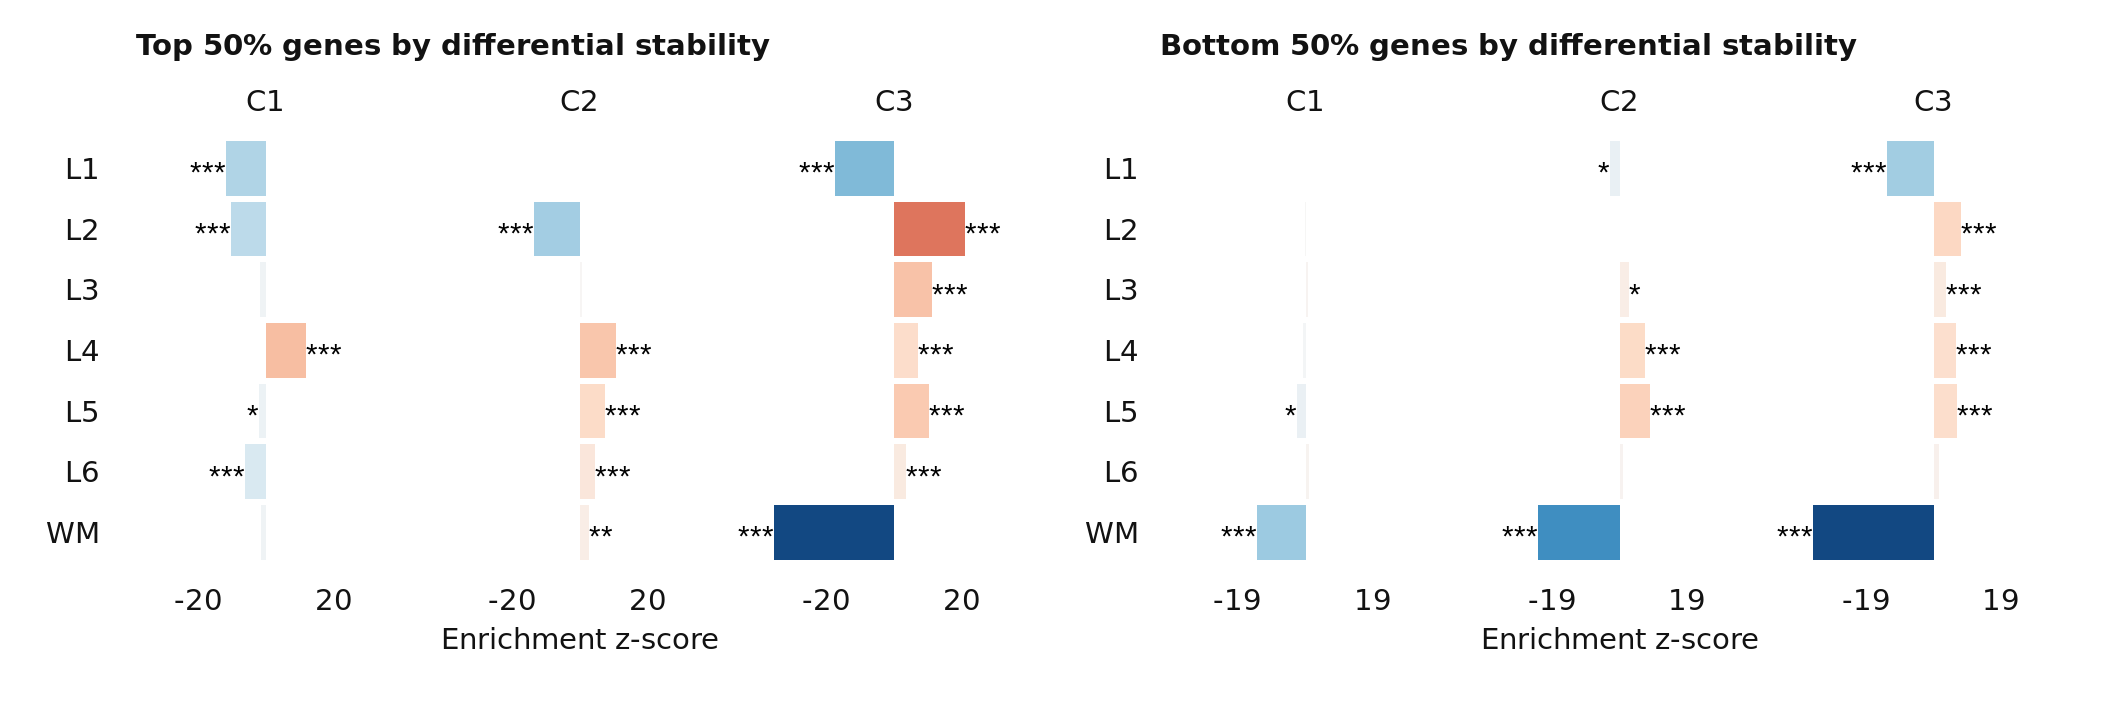

In [37]:
%%R -i layer_stats -i layer_stats_complement -i cell_stats -i cell_stats_complement -w 180 -h 60 --units mm -r 300
source("../code/fig1_plots.R")

g1 <- plot_enrichment_bars_z(layer_stats) + ggtitle("Top 50% genes by differential stability")
g1c <- plot_enrichment_bars_z(layer_stats_complement) + ggtitle("Bottom 50% genes by differential stability")

(g1 + g1c) & theme(aspect.ratio=1.5)

### Single cell cross plot

In [38]:
sc_projected_posneg_plot = format_single_cell_projected_for_plot()

In [39]:
sc_cross_plot = (sc_projected_posneg_plot
 .drop('negative',axis=1).rename({'C':'C_positive'},axis=1)
 .join(sc_projected_posneg_plot.rename({'C':'C_negative'},axis=1).loc[:,['C_negative','negative']])
)

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


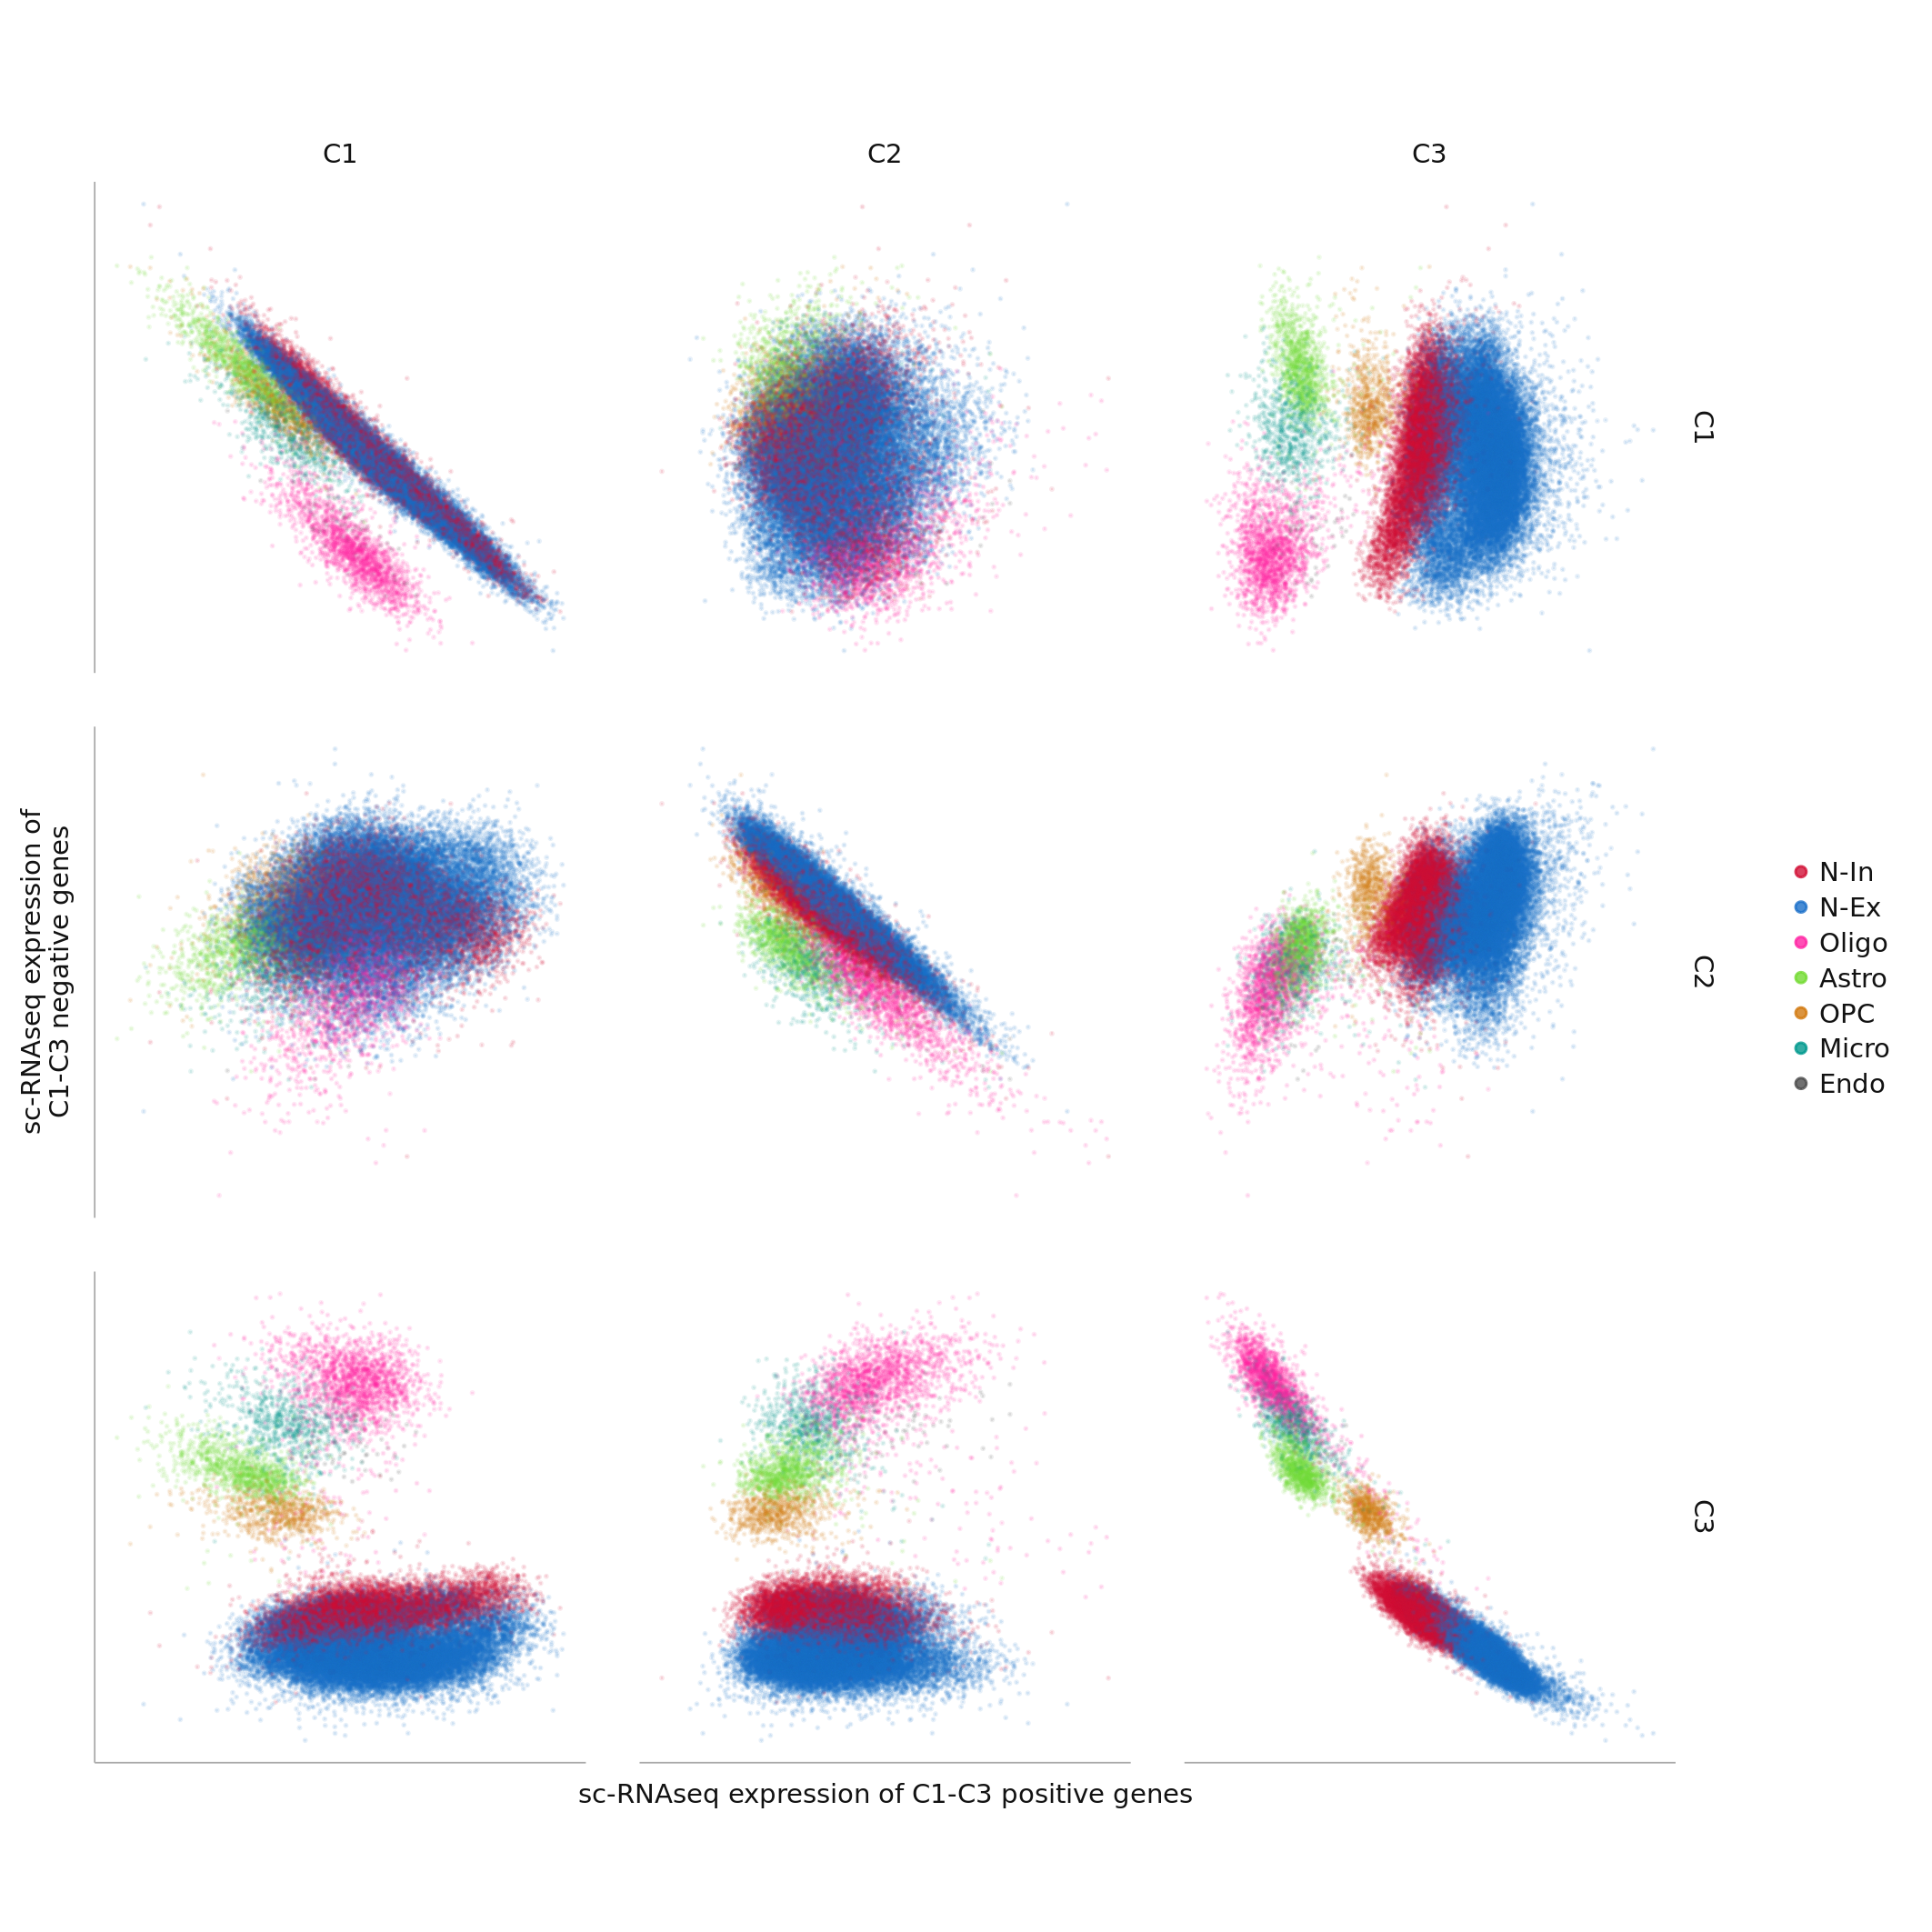

In [40]:
%%R -i sc_cross_plot -w 180 -h 180 -u mm -r 300
colors <- c(
        brewer.rdbu(21)[c(2,20)],
        brewer.piyg(11)[c(2,10)],
        brewer.brbg(11)[c(2,10)]
    ) %>% 
    brightness(scalefac(1.5)) %>% 
    # saturation(scalefac(1.2)) %>% 
    c('grey30')

sc_cross_plot %>% 
mutate(cell_type = factor(cell_type, ordered=T, levels=unique(.$cell_type))) %>% 
ggplot(aes(positive, negative)) + 
facet_grid(C_negative~C_positive, scales='free') + 
geom_point(alpha=.1, size=.002, aes(color=cell_type)) +
xlab("sc-RNAseq expression of C1-C3 positive genes") +
ylab("sc-RNAseq expression of\nC1-C3 negative genes") +
scale_color_manual(values=colors, name=NULL) +
guides(colour = guide_legend(byrow=T, override.aes = list(size=1, alpha=.8))) +
theme_classic() + 
theme(
    text = element_text(size=7, family = 'Calibri', color = 'grey7'),
    strip.text = element_text(size=7, family = 'Calibri', color = 'grey7', angle=0),
    strip.background = element_blank(),
    strip.placement='outside',
    panel.grid = element_blank(),
    panel.spacing.x = unit(5,'mm'),
    panel.spacing.y = unit(5,'mm'),
    legend.spacing.y = unit(1,'mm'),
    legend.key.size = unit(0.5, "mm"),
    legend.text = element_text(size=7),
    axis.line = element_line(size=.2, color='darkgrey'),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    aspect.ratio = 1
)


### MAGMA

In [41]:
pd.read_csv(path + disorder + '.' + method + '.gsa.out', skiprows=4, sep=r'\s+')

NameError: name 'path' is not defined

In [42]:
path = "../magma/enrichment_analysis/"

results = []
for disorder in ['ASD-matoba', 'MDD', 'SCZ', 'AZ']:
# for disorder in ['ASD-matoba', 'SCZ']:
    for method in ['magma', 'hmagma_adult', 'hmagma_fetal']:
        _results = (pd.read_csv(path + disorder + '.' + method + '.gsa.out', skiprows=4, sep=r'\s+')
                    .assign(label = disorder, method = method))
        results.append(_results)

magma_results = (pd.concat(results)
 .loc[:, ['method', 'label', 'VARIABLE', 'NGENES', 'BETA', 'P']]
 .rename({'VARIABLE':'C', 'NGENES':'n_genes', 'BETA':'beta', 'P':'p'}, axis=1)
 .replace({
     'label': {'ASD-matoba':'ASD'},
     'method': {'hmagma_adult':'hmagma'}
    })
 .set_index(['method', 'label', 'C'])
 .assign(
    #  q = lambda x: multipletests(x['p'], method='fdr_bh')[1]
    q = lambda x: x.groupby(level=[0,1])
                   .apply(lambda y: pd.Series(multipletests(y['p'], method='fdr_bh')[1], index=y.index))
                   .reset_index([0,1], drop=True) # make index match
 )
)
magma_results

n_genes      beta         p         q
method       label C                                        
magma        ASD   C1     6938  0.026748  0.178710  0.178710
                   C2     6938 -0.075489  0.039124  0.117372
                   C3     6938  0.066767  0.137890  0.178710
hmagma       ASD   C1     7166  0.054386  0.004096  0.012289
                   C2     7166 -0.074016  0.032233  0.048349
                   C3     7166  0.042316  0.321660  0.321660
hmagma_fetal ASD   C1     7152  0.025418  0.188620  0.188620
                   C2     7152 -0.059461  0.093065  0.188620
                   C3     7152  0.064884  0.134250  0.188620
magma        MDD   C1     2156  0.024053  0.204480  0.204480
                   C2     2156 -0.060165  0.087005  0.130507
                   C3     2156  0.078174  0.062902  0.130507
hmagma       MDD   C1      939 -0.018643  0.499930  0.749895
                   C2      939  0.050347  0.324140  0.749895
                   C3      939  0.007995  0.898370  0.898370
hmagma_fetal MDD   C1      945  0.003647  0.902760  0.902760
                   C2      945 -0.064662  0.241850  0.707835
                   C3      945 -0.048397  0.471890  0.707835
magma        SCZ   C1     6948  0.045958  0.088142  0.132213
                   C2     6948 -0.002140  0.966090  0.966090
                   C3     6948  0.243550  0.000086  0.000257
hmagma       SCZ   C1     7260  0.002011  0.932200  0.932200
                   C2     7260 -0.076476  0.079560  0.119340
                   C3     7260  0.161040  0.002868  0.008604
hmagma_fetal SCZ   C1     7258  0.027584  0.247670  0.247670
                   C2     7258 -0.075439  0.087078  0.130617
                   C3     7258  0.197470  0.000317  0.000951
magma        AZ    C1     6887  0.033288  0.117800  0.353400
                   C2     6887  0.013242  0.740330  0.831960
                   C3     6887  0.010193  0.831960  0.831960
hmagma       AZ    C1     7260  0.023616  0.245540  0.368310
                   C2     7260 -0.021721  0.563400  0.563400
                   C3     7260 -0.085280  0.065626  0.196878
hmagma_fetal AZ    C1     7261  0.003961  0.850250  0.850250
                   C2     7261 -0.033743  0.380310  0.570465
                   C3     7261 -0.056873  0.232640  0.570465

In [43]:
gwas_genes = get_gwas_combined(az=True)
gwas_stats = compute_null_p(*compute_enrichments(weights, null_weights, gwas_genes), adjust_by_label=True)

permutation_results = (gwas_stats
    .assign(method='prioritized')
    .loc[:, ['method', 'label', 'C', 'n_genes', 'z', 'p', 'q']]
)
permutation_results

,method,label,C,n_genes,z,p,q
0,prioritized,ASD,C1,235,2.279092,0.0208,0.0312
1,prioritized,ASD,C2,235,-2.373203,0.0180,0.0312
2,prioritized,ASD,C3,235,0.452148,0.6460,0.6460
3,prioritized,MDD,C1,269,1.531932,0.1296,0.1944
4,prioritized,MDD,C2,269,-1.741602,0.0828,0.1944
5,prioritized,MDD,C3,269,0.826582,0.4036,0.4036
6,prioritized,SCZ,C1,618,2.122365,0.0388,0.0582
7,prioritized,SCZ,C2,618,-0.895271,0.3756,0.3756
8,prioritized,SCZ,C3,618,2.494416,0.0096,0.0288
9,prioritized,AZ,C1,55,-0.682960,0.4800,0.7200


In [44]:
gwas_methods = (pd.concat([
        permutation_results, 
        magma_results.reset_index().rename({'beta':'z'}, axis=1)
    ])
    .assign(facet = lambda x: np.where(x['label'] == 'AZ', 2, 1))
)
gwas_methods

,method,label,C,n_genes,z,p,q,facet
0,prioritized,ASD,C1,235,2.279092,0.020800,0.031200,1
1,prioritized,ASD,C2,235,-2.373203,0.018000,0.031200,1
2,prioritized,ASD,C3,235,0.452148,0.646000,0.646000,1
3,prioritized,MDD,C1,269,1.531932,0.129600,0.194400,1
4,prioritized,MDD,C2,269,-1.741602,0.082800,0.194400,1
5,prioritized,MDD,C3,269,0.826582,0.403600,0.403600,1
6,prioritized,SCZ,C1,618,2.122365,0.038800,0.058200,1
7,prioritized,SCZ,C2,618,-0.895271,0.375600,0.375600,1
8,prioritized,SCZ,C3,618,2.494416,0.009600,0.028800,1
9,prioritized,AZ,C1,55,-0.682960,0.480000,0.720000,2


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


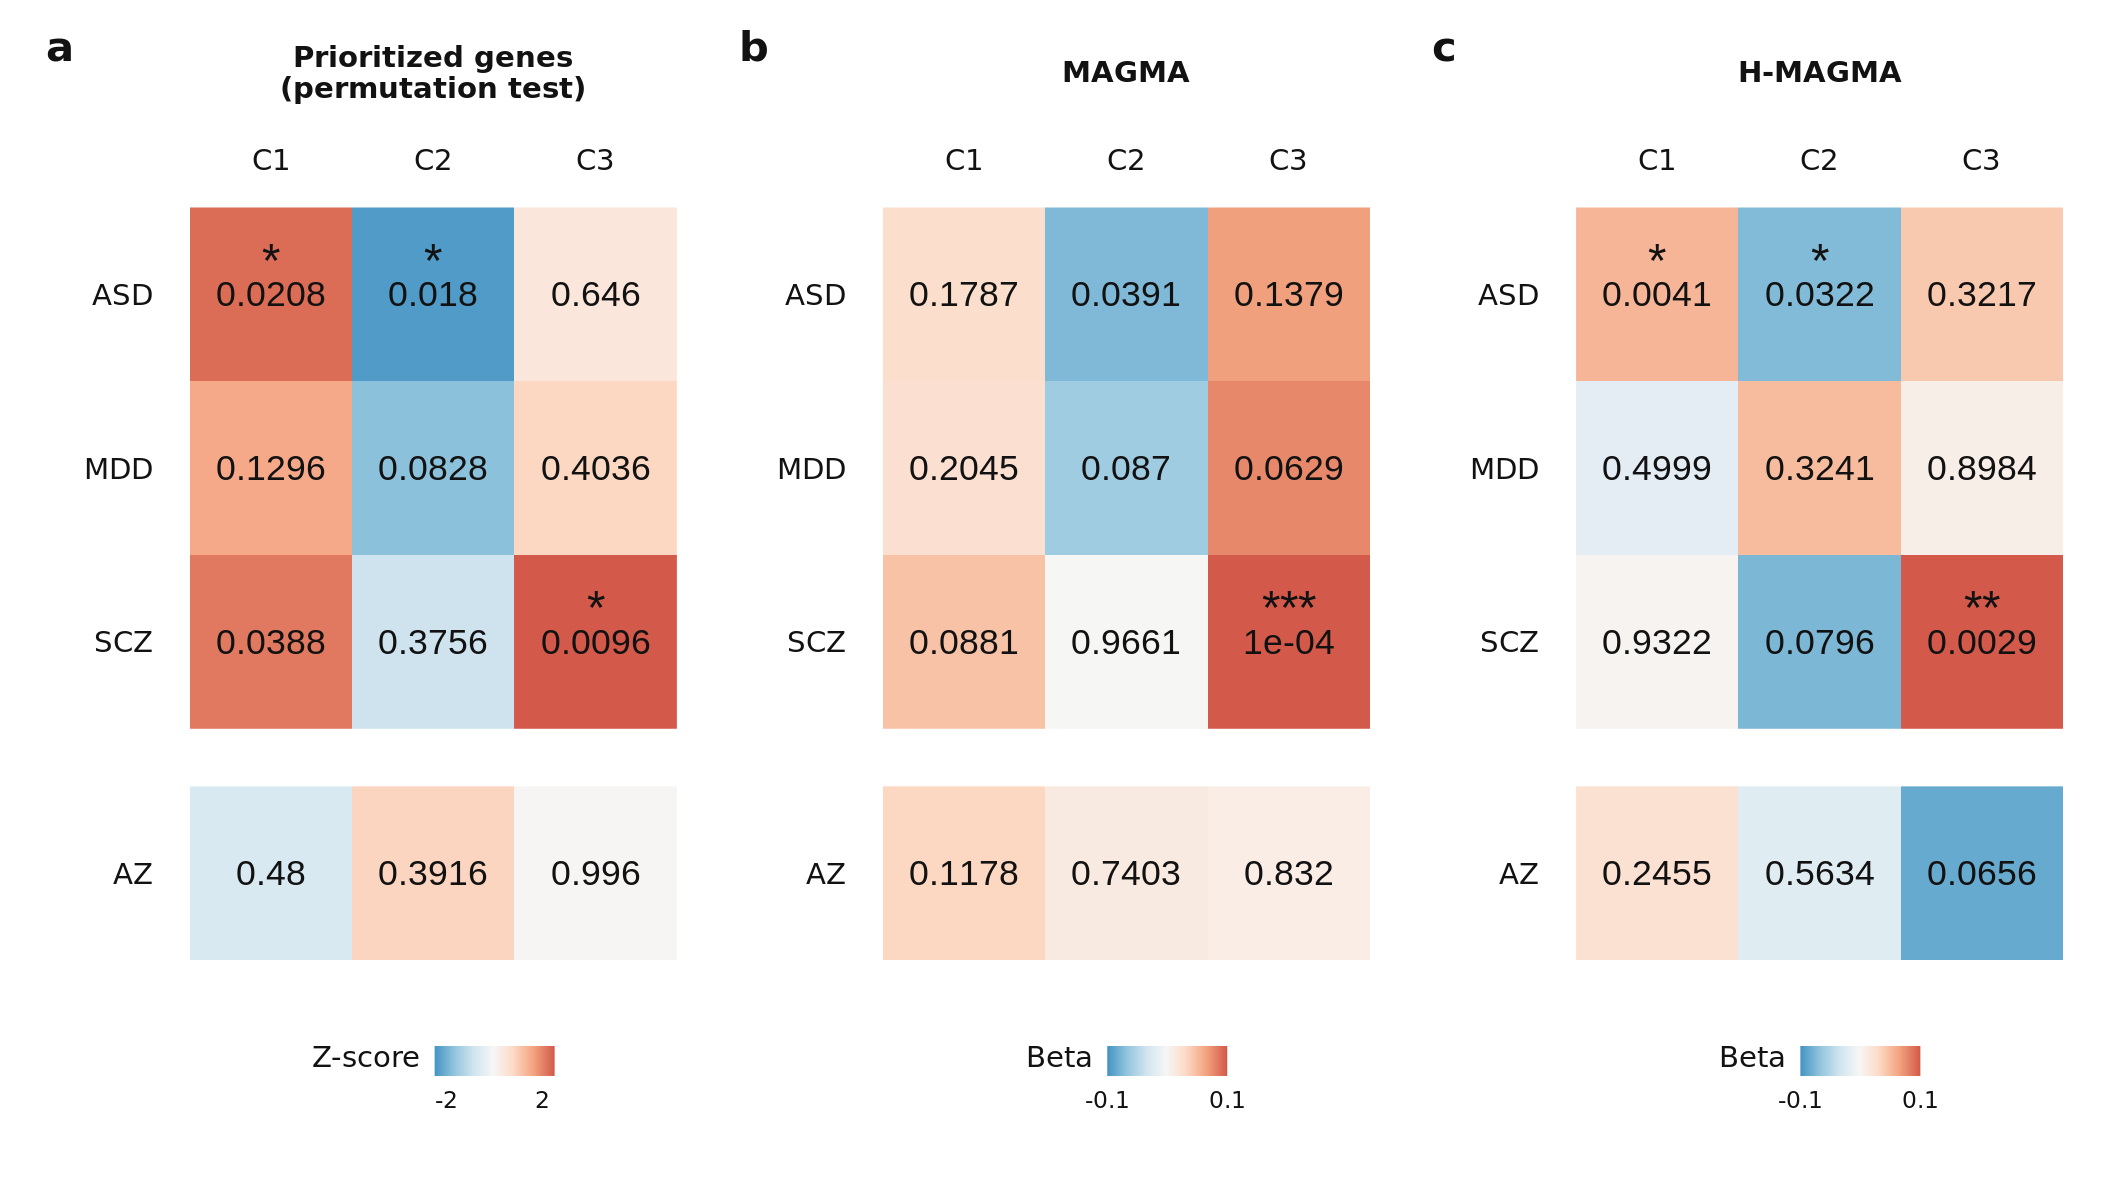

In [45]:
%%R -i gwas_methods -w 180 -h 100 -u mm -r 300
source("../code/fig_supplement.R")

g1 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='prioritized')) + ggtitle('Prioritized genes\n(permutation test)')
g2 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='magma'), name='Beta', limits=0.1) + ggtitle('MAGMA')
g3 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='hmagma'), name='Beta', limits=0.1) + ggtitle('H-MAGMA')

(g1 + g2 + g3) + plot_annotation(tag_level='a')

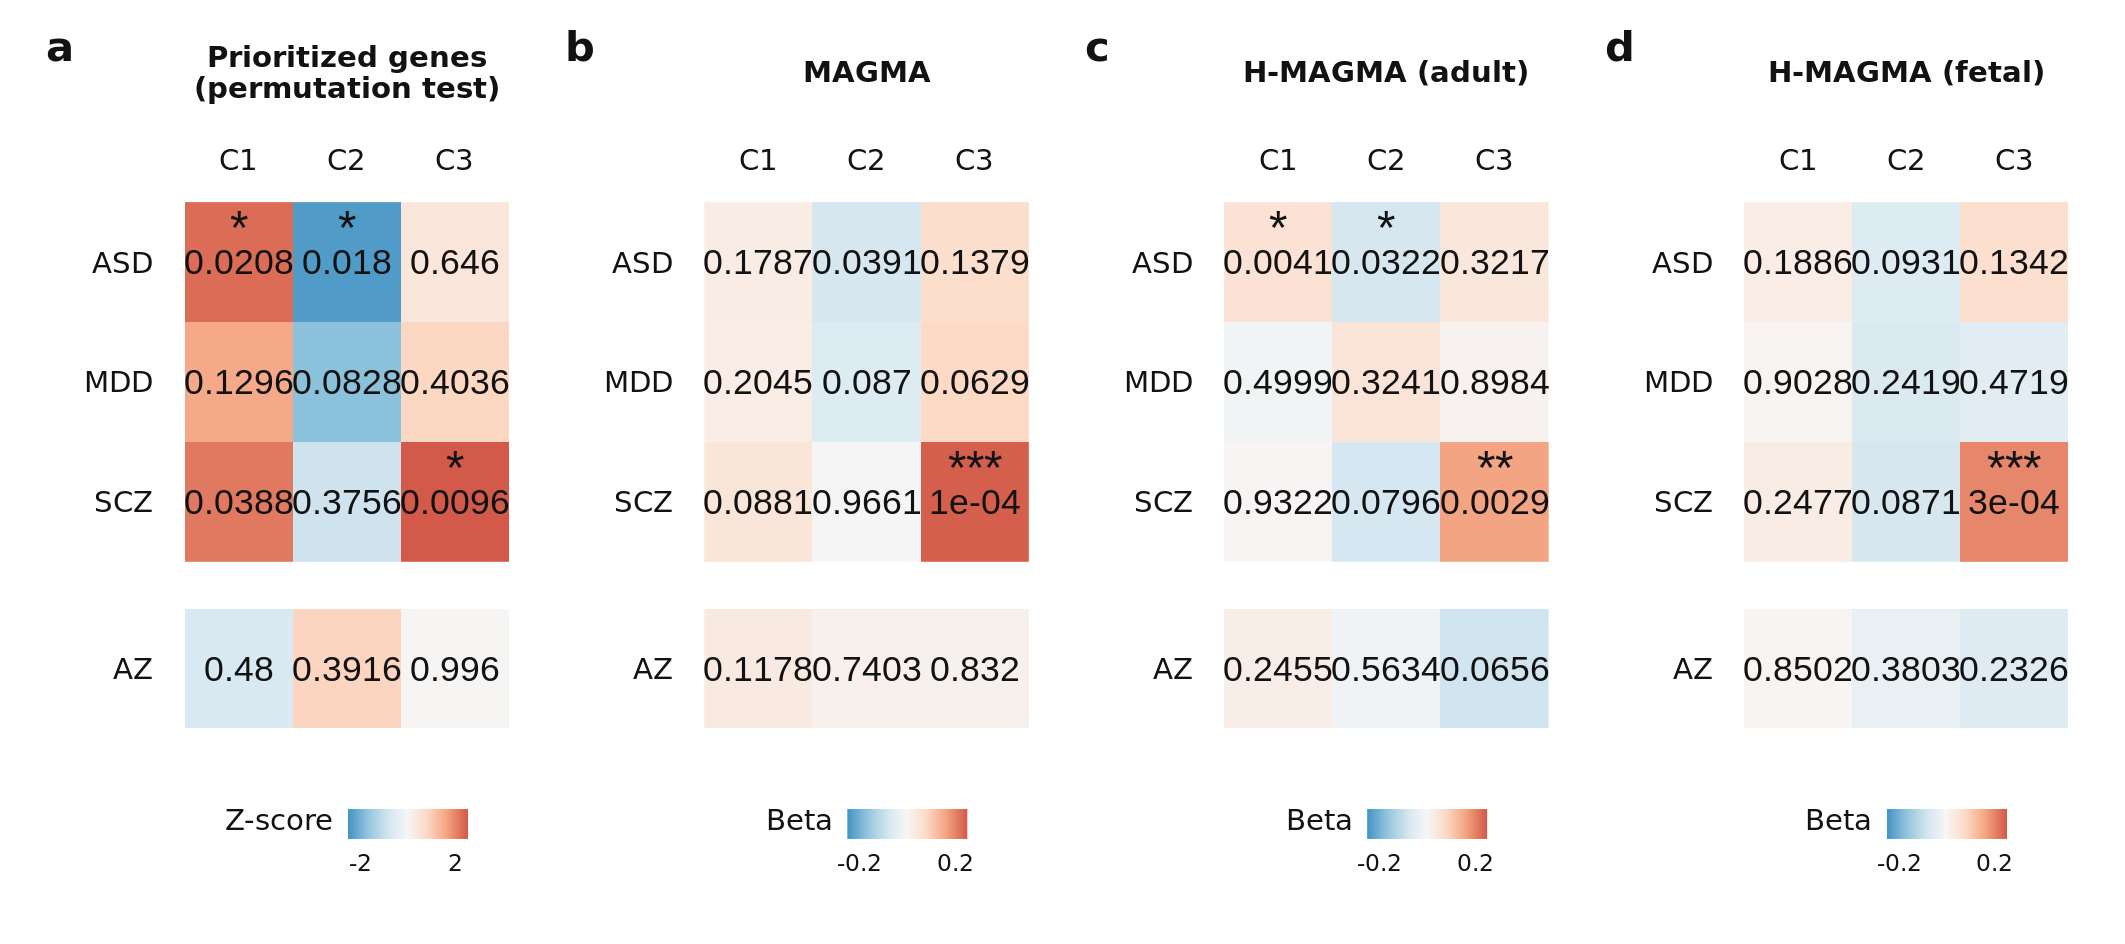

In [46]:
%%R -i gwas_methods -w 180 -h 80 -u mm -r 300
source("../code/fig_supplement.R")

g1 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='prioritized')) + ggtitle('Prioritized genes\n(permutation test)')
g2 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='magma'), name='Beta', limits=0.25) + ggtitle('MAGMA')
g3 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='hmagma'), name='Beta', limits=0.25) + ggtitle('H-MAGMA (adult)')
g4 <- plot_heatmap_enrichments(gwas_methods %>% filter(method=='hmagma_fetal'), name='Beta', limits=0.25) + ggtitle('H-MAGMA (fetal)')

(g1 + g2 + g3 + g4) + plot_layout(ncol=4) + plot_annotation(tag_level='a')

### Test for enrichment of AZ genes

In [47]:
az_gwas = (pd.read_csv("../data/gwas/bellenguez2022_tableS20.csv", skiprows=2)
 .assign(label = 'Bellenguez')
 .loc[lambda x: np.isin(x['Gene Prioritization Tier'], ['Tier 1', 'Tier 2']), ['label', 'Gene']]
 .rename({'Gene':'gene'}, axis=1)
)

In [48]:
compute_null_p(*compute_enrichments(weights, null_weights, az_gwas), adjust_by_label=False)

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,Bellenguez,C1,0.2400,-0.116177,-0.035423,0.118241,-0.682960,False,0.4800,0.720,False,55,24
1,Bellenguez,C2,0.8042,0.081797,0.026152,0.064671,0.860428,True,0.3916,0.720,False,55,24
2,Bellenguez,C3,0.4980,0.006884,0.006716,0.052820,0.003194,False,0.9960,0.996,False,55,24


---